In [1]:
%load_ext autoreload
%autoreload 2
from naml.modules import torch, nn, optim, tqdm
from naml.util import run_epochs
from naml import plot

In [2]:
def f(x : torch.Tensor):
    return torch.sin(x) + x**0.8 

noise = 0.5
n_train = 50

x_train, indices = torch.sort(torch.rand(n_train) * 5)
y_train = f(x_train) + torch.normal(0, 0.5, x_train.shape) * noise

x_test = torch.linspace(0, 5, n_train)
y_true = f(x_test)

x_train, y_train

(tensor([0.0054, 0.0762, 0.1916, 0.2247, 0.2280, 0.2747, 0.3318, 0.3621, 0.3787,
         0.4805, 0.6440, 0.9088, 0.9545, 1.2165, 1.3653, 1.4763, 1.5928, 1.5957,
         1.6124, 1.6188, 1.7690, 1.8085, 1.8272, 1.8347, 1.9320, 1.9987, 2.2763,
         2.6645, 2.7730, 3.0633, 3.3206, 3.3820, 3.3906, 3.4661, 3.5872, 3.6537,
         3.7968, 3.8285, 4.1573, 4.3555, 4.5328, 4.5670, 4.5693, 4.5796, 4.6014,
         4.7135, 4.7285, 4.8098, 4.8229, 4.8531]),
 tensor([ 0.1412, -0.1935,  0.5907,  0.8946,  0.2823,  0.3317,  0.1571,  0.3625,
          0.8944,  1.3573,  1.0386,  1.5169,  1.5653,  2.1309,  2.1942,  2.0694,
          2.4823,  2.6753,  2.7294,  3.0525,  2.6830,  2.2108,  2.6323,  2.5718,
          2.9574,  2.7084,  2.5766,  2.8561,  2.5709,  2.4613,  2.4594,  2.7274,
          2.4910,  2.4438,  2.1732,  2.0898,  2.1910,  2.3524,  2.5228,  2.4493,
          2.4670,  1.7160,  2.3853,  2.6500,  2.7764,  2.5573,  2.3518,  1.9955,
          2.5311,  2.7796]))

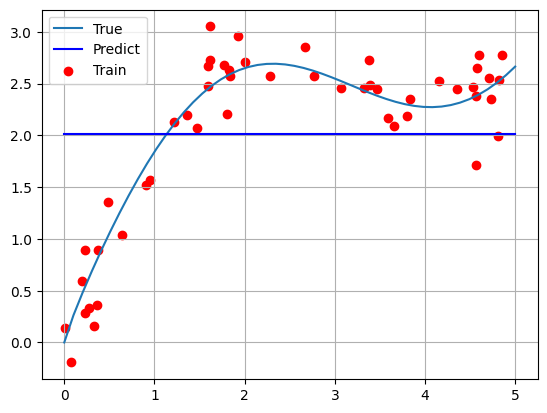

In [3]:
# Average pooling
y_hat = torch.repeat_interleave(y_train.mean(), n_train)
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

In [4]:
# Weighted with Gaussian kernel
x_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)
x_repeat, x_train

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1020, 0.1020, 0.1020,  ..., 0.1020, 0.1020, 0.1020],
         [0.2041, 0.2041, 0.2041,  ..., 0.2041, 0.2041, 0.2041],
         ...,
         [4.7959, 4.7959, 4.7959,  ..., 4.7959, 4.7959, 4.7959],
         [4.8980, 4.8980, 4.8980,  ..., 4.8980, 4.8980, 4.8980],
         [5.0000, 5.0000, 5.0000,  ..., 5.0000, 5.0000, 5.0000]]),
 tensor([0.0054, 0.0762, 0.1916, 0.2247, 0.2280, 0.2747, 0.3318, 0.3621, 0.3787,
         0.4805, 0.6440, 0.9088, 0.9545, 1.2165, 1.3653, 1.4763, 1.5928, 1.5957,
         1.6124, 1.6188, 1.7690, 1.8085, 1.8272, 1.8347, 1.9320, 1.9987, 2.2763,
         2.6645, 2.7730, 3.0633, 3.3206, 3.3820, 3.3906, 3.4661, 3.5872, 3.6537,
         3.7968, 3.8285, 4.1573, 4.3555, 4.5328, 4.5670, 4.5693, 4.5796, 4.6014,
         4.7135, 4.7285, 4.8098, 4.8229, 4.8531]))

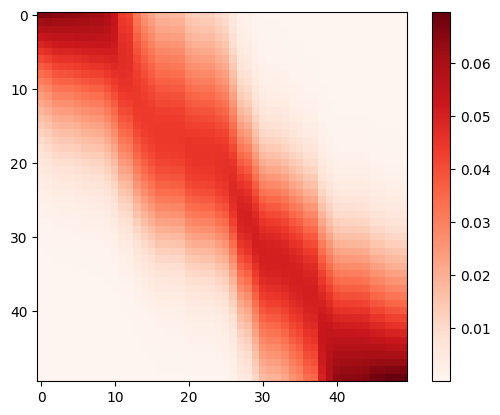

In [5]:
# Closer points have higher weights
w = nn.functional.softmax(-((x_repeat - x_train)**2) / 2, dim=1)
plot.heatmap(w)

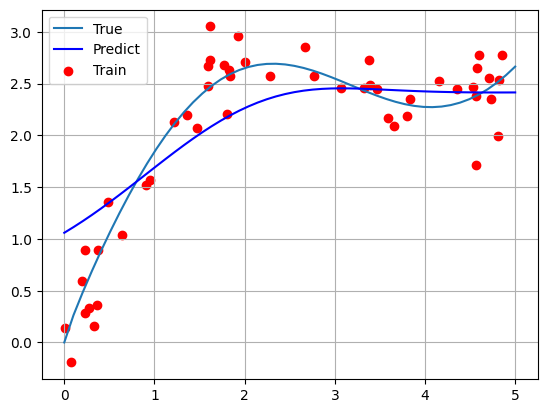

In [6]:
# Nadaraya-Watson kernel regression
y_hat = w @ y_train
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

In [7]:
class Net(nn.Module):
    M_w : torch.Tensor
    w : nn.Parameter

    def __init__(self):
        super().__init__()
        # Hyperparameter tuning
        # We're only learning the w parameter
        self.w = nn.Parameter(torch.randn(1), requires_grad=True)
        
    def forward(self, q : torch.Tensor, k : torch.Tensor, v : torch.Tensor):
        M_q = q.repeat_interleave(k.shape[-1]).reshape(-1, k.shape[1])
        self.M_w = M_w = nn.functional.softmax(-(((M_q - k) * self.w) **2) / 2, dim=1)
        return (M_w.unsqueeze(1) @ v.unsqueeze(-1)).reshape(-1) # Flatten
    
x_tiled = x_train.repeat((n_train,1))
y_tiled = y_train.repeat((n_train,1))

print((1-torch.eye(n_train)).bool())
k, v = x_tiled, y_tiled
print(k.shape, v.shape)
# Samples are not allowed to attend to themselves
# XXX: What if we allow this?
k, v = x_tiled[(1-torch.eye(n_train)).bool()], y_tiled[(1-torch.eye(n_train)).bool()]
k, v = k.reshape(-1, n_train-1), v.reshape(-1, n_train-1)
print(k.shape, v.shape)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])
torch.Size([50, 50]) torch.Size([50, 50])
torch.Size([50, 49]) torch.Size([50, 49])


In [8]:
# Train
net = Net()
loss = nn.MSELoss(reduction='none')
list(net.parameters())

[Parameter containing:
 tensor([0.6703], requires_grad=True)]

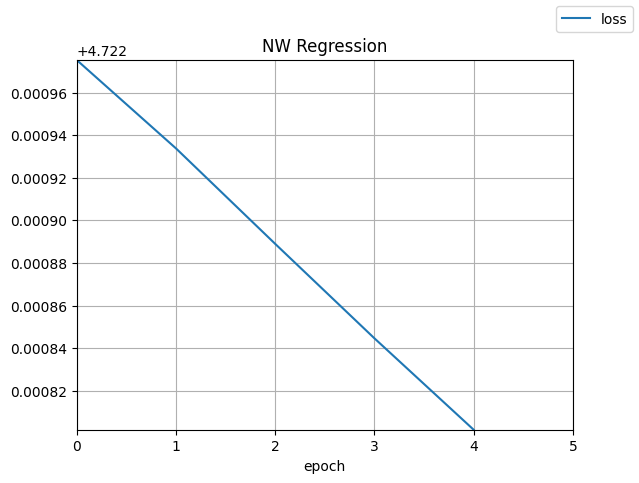

  0%|          | 0/5 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [14]:
opt = optim.SGD(net.parameters(), lr=0.5)
@run_epochs("NW Regression")
def train():
    opt.zero_grad()
    l : torch.Tensor = loss(net(x_train, k, v), y_train)
    l.sum().backward()
    opt.step()        
    return l.sum().detach()
train(5)

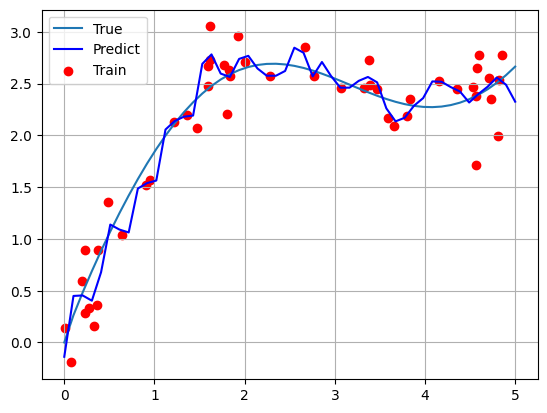

In [10]:
y_hat = net(x_test, k, v).unsqueeze(1).detach()
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

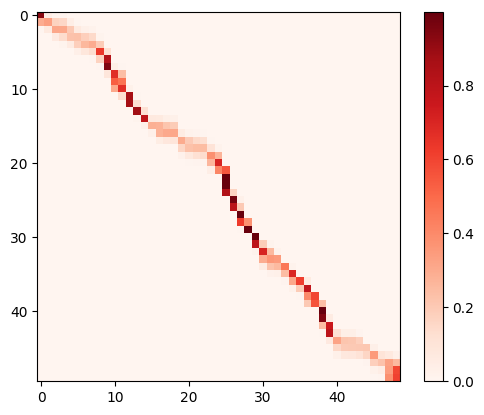

In [11]:
plot.heatmap(net.M_w)